<a href="https://colab.research.google.com/github/jecampagne/ML-toys/blob/main/Test_MADE_NVP_MAF_IAF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 16

import numpy as np

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

tf.enable_v2_behavior()

In [3]:
tf.__version__

'2.8.2'

In [6]:
tf.random.set_seed(0)

# Essai de MADE (1 couche)

In [85]:
n = 10_000
x2 = np.random.randn(n).astype(dtype=np.float32) * 2.
x1 = np.random.randn(n).astype(dtype=np.float32) + (x2 * x2 / 4.)
data = np.stack([x1, x2], axis=-1)


In [86]:
data.shape

(10000, 2)

In [ ]:
joint = tfd.JointDistributionSequential([
  tfd.Normal(loc=0,scale=2), # x2
  lambda x2: tfd.Normal(loc=x2*x2/4.,scale=1)],
  batch_ndims=0, use_vectorized_map=True)


In [ ]:
n = 2_000
x2b,x1b = joint.sample(sample_shape=(n))

In [ ]:
data_bis = np.stack([x2b, x1b], axis=-1)

In [ ]:
x = np.linspace(-3,6)
y = np.linspace(-6,6)
xv, yv = np.meshgrid(x, y, sparse=True)
z = joint.prob(x2=yv,x=xv)

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.scatter(x1,x2,s=0.1)
plt.hist2d(x1,x2,density=True,bins=[100,100])
plt.contour(x,y,z)
plt.gca().set_aspect('equal')
plt.xlim([x.min(),x.max()])
plt.ylim([y.min(),y.max()])
plt.draw()

In [ ]:
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[10, 10], activation='leaky_relu')

In [ ]:
# A base distribtion as 2D Normal
base_dist=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[2])
# generate 10 samples 2D
base_spl = base_dist.sample(sample_shape=(10_000))

In [ ]:
# The base distribution transformed by a MADE bijector
trans_dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=tfb.MaskedAutoregressiveFlow(made))


In [ ]:
x_ = tfkl.Input(shape=(2,), dtype=tf.float32)
log_prob_ = trans_dist.log_prob(x_)
model = tfk.Model(x_, log_prob_)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                loss=lambda _, log_prob: -log_prob) # signature of loss fn(y_true,output_of_the_model)

batch_size = 25
model.fit(x=data,
            y=np.zeros((n, 0), dtype=np.float32),
            batch_size=batch_size,
            epochs=50,
            steps_per_epoch=1,  # Usually `n // batch_size`.
            shuffle=True,
            verbose=True)

In [ ]:
spl= trans_dist.sample(100_000)

In [ ]:
fig = plt.figure(figsize=(5,5))
#plt.scatter(spl[:,0],spl[:,1],s=0.1)
plt.hist2d(spl[:,0],spl[:,1],density=True,bins=[100,200])
#plt.scatter(base_spl[:,0],base_spl[:,1],s=0.1,c="k")
#plt.contour(x,y,z)
plt.gca().set_aspect('equal')

plt.xlim([x.min(),x.max()])
plt.ylim([y.min(),y.max()])
plt.draw()

# MAF/IAF

In [35]:
sess =tf.compat.v1.InteractiveSession()


In [190]:
DTYPE=tf.float32
NP_DTYPE=np.float32
MODEL = 'MAF' # Which Normalizing Flow to use. 'MAF' or 'IAF'
TARGET_DENSITY = 'MOONS' # Which dataset to model. 
USE_BATCHNORM = False

In [191]:
# dataset-specific settings
settings = {
    'SIGGRAPH': {
        'batch_size': 1500,
        'num_bijectors': 8,
        'train_iters': 2e5
    },
    'MOONS': {
        'batch_size': 100,
        'num_bijectors': 4,
        'train_iters': 2e4
    },
    'MAFGAUSS':{
        'batch_size': 100,
        'num_bijectors': 4,
        'train_iters': 2e4
    }
}

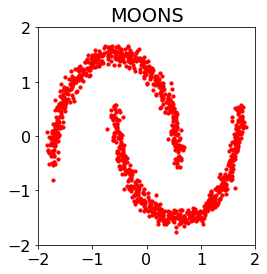

In [192]:
if TARGET_DENSITY == 'SIGGRAPH':
    import pickle
    with open('siggraph.pkl', 'rb') as f:
        X = np.array(pickle.load(f))
    X -= np.mean(X, axis=0)  # center
    xlim, ylim = [-4, 4], [-2, 2]
elif TARGET_DENSITY == 'MOONS':
    from sklearn import cluster, datasets, mixture
    from sklearn.preprocessing import StandardScaler
    n_samples = 1000
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
    X, y = noisy_moons
    X = StandardScaler().fit_transform(X)
    xlim, ylim = [-2, 2], [-2, 2]
elif TARGET_DENSITY == 'GAUSSIAN':
    mean = [0.4, 1]
    A = np.array([[2, .3], [-1., 4]])
    cov = A.T.dot(A)
    print(mean)
    print(cov)
    X = np.random.multivariate_normal(mean, cov, 2000)
    xlim, ylim = [-2, 2], [-2, 2]
elif TARGET_DENSITY == 'MAFGAUSS':
    n=2000
    x2 = np.random.randn(n).astype(dtype=np.float32) * 2.
    x1 = np.random.randn(n).astype(dtype=np.float32) + (x2 * x2 / 4.)
    X = np.stack([x1, x2], axis=-1)
    xlim, ylim = [-4, 8], [-6, 6]

X = X.astype(np.float32)
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.title(TARGET_DENSITY)
plt.xlim(xlim)
plt.ylim(ylim)
plt.gca().set_aspect('equal')

In [193]:
X[0]

array([-0.19579744, -0.8763679 ], dtype=float32)

In [194]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE),name='base dist')

In [195]:
class BatchNorm(tfb.Bijector):
    def __init__(self, eps=1e-5, decay=0.95, validate_args=False, name="batch_norm"):
        super(BatchNorm, self).__init__(
            event_ndims=1, validate_args=validate_args, name=name)
        self._vars_created = False
        self.eps = eps
        self.decay = decay

    def _create_vars(self, x):
        n = x.get_shape().as_list()[1]
        with tf.variable_scope(self.name):
            self.beta = tf.get_variable('beta', [1, n], dtype=DTYPE)
            self.gamma = tf.get_variable('gamma', [1, n], dtype=DTYPE)
            self.train_m = tf.get_variable(
                'mean', [1, n], dtype=DTYPE, trainable=False)
            self.train_v = tf.get_variable(
                'var', [1, n], dtype=DTYPE, initializer=tf.ones_initializer, trainable=False)
        self._vars_created = True

    def _forward(self, u):
        if not self._vars_created:
            self._create_vars(u)
        return (u - self.beta) * tf.exp(-self.gamma) * tf.sqrt(self.train_v + self.eps) + self.train_m

    def _inverse(self, x):
        # Eq 22. Called during training of a normalizing flow.
        if not self._vars_created:
            self._create_vars(x)
        # statistics of current minibatch
        m, v = tf.nn.moments(x, axes=[0], keep_dims=True)
        # update train statistics via exponential moving average
        update_train_m = tf.assign_sub(
            self.train_m, self.decay * (self.train_m - m))
        update_train_v = tf.assign_sub(
            self.train_v, self.decay * (self.train_v - v))
        # normalize using current minibatch statistics, followed by BN scale and shift
        with tf.control_dependencies([update_train_m, update_train_v]):
            return (x - m) * 1. / tf.sqrt(v + self.eps) * tf.exp(self.gamma) + self.beta

    def _inverse_log_det_jacobian(self, x):
        # at training time, the log_det_jacobian is computed from statistics of the
        # current minibatch.
        if not self._vars_created:
            self._create_vars(x)
        _, v = tf.nn.moments(x, axes=[0], keep_dims=True)
        abs_log_det_J_inv = tf.reduce_sum(
            self.gamma - .5 * tf.log(v + self.eps))
        return abs_log_det_J_inv

In [196]:
num_bijectors = settings[TARGET_DENSITY]['num_bijectors']
bijectors = []

for i in range(num_bijectors):
    if MODEL == 'NVP':
        #bijectors.append(NVPCoupling(D=2, d=1, layer_id=i))
        raise Exception("To be done with TF implementation") 
    elif MODEL == 'MAF':
        #bijectors.append(tfb.MaskedAutoregressiveFlow(
        #    shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
        #        hidden_layers=[512, 512])))
        bijectors.append(tfb.MaskedAutoregressiveFlow( name ='MAF%d' %i, 
            shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
                params=2, hidden_units=[512, 512])))
    elif MODEL == 'IAF':
        #bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(
        #    shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
        #        hidden_layers=[512, 512]))))
        bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(name ='IAF%d' %i,
            shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
                params=2, hidden_units=[512, 512]))))
    if USE_BATCHNORM and i % 2 == 0:
        # BatchNorm helps to stabilize deep normalizing flows, esp. Real-NVP
        #bijectors.append(BatchNorm(name='batch_norm%d' % i))
        bijectors.append(tfb.BatchNormalization(name='BN%d' % i))
    bijectors.append(tfb.Permute(permutation=[1, 0]))
# Discard the last Permute layer.
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

In [197]:
X.shape

(1000, 2)

In [198]:
trans_dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=flow_bijector)


In [199]:
trans_dist.bijector.forward(X)

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[-0.8977675 , -0.20175195],
       [ 1.441589  , -1.0398935 ],
       [ 0.802679  , -1.5247128 ],
       ...,
       [ 0.412042  , -1.7038785 ],
       [-0.05127002, -1.619414  ],
       [-1.415656  ,  0.34289464]], dtype=float32)>

In [200]:
- tf.reduce_mean(trans_dist.log_prob(X))

<tf.Tensor: shape=(), dtype=float32, numpy=2.8731174>

In [201]:
# visualization
x = base_dist.sample(8000)
samples = [x]
names = [base_dist.name]
for bijector in reversed(trans_dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)


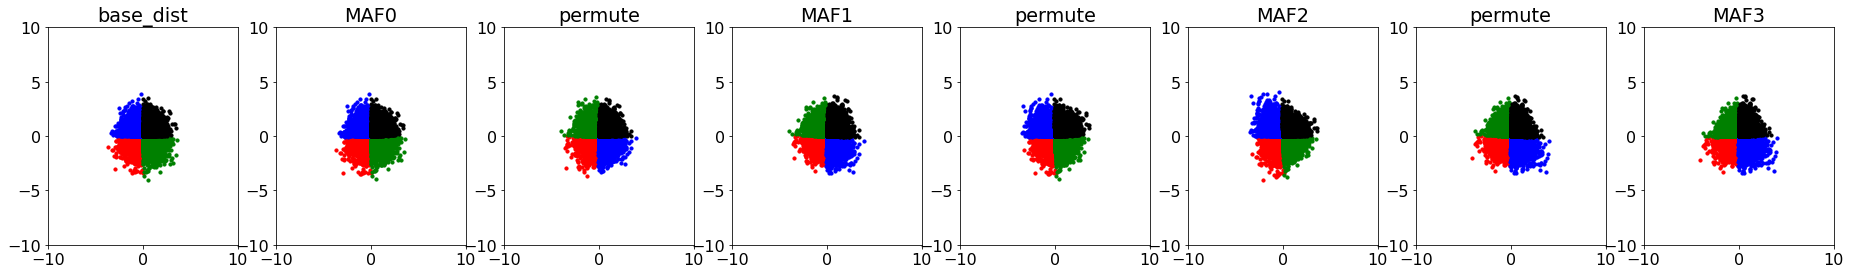

In [202]:
results = samples
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0].numpy()
for i in range(len(results)):
    X1 = results[i].numpy()
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([-10, 10])
    arr[i].set_ylim([-10, 10])
    arr[i].set_title(names[i])


In [203]:
x_ = tfkl.Input(shape=(2,), dtype=tf.float32)
log_prob_ = trans_dist.log_prob(x_)
model = tfk.Model(x_, log_prob_)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
                loss=lambda _, log_prob: -tf.reduce_mean(log_prob)) # signature of loss fn(y_true,output_of_the_model)

NUM_STEPS = int(settings[TARGET_DENSITY]['train_iters'])
BATCH_SIZE = int(settings[TARGET_DENSITY]['batch_size'])

hist = model.fit(x=X,
            y=np.zeros((n_samples, 0), dtype=np.float32),
            batch_size=BATCH_SIZE,
            epochs=1_000,
            steps_per_epoch=n_samples//BATCH_SIZE,  # Usually `n // batch_size`.
            shuffle=True,
            verbose=0)

In [204]:
hist.history.keys()

dict_keys(['loss'])

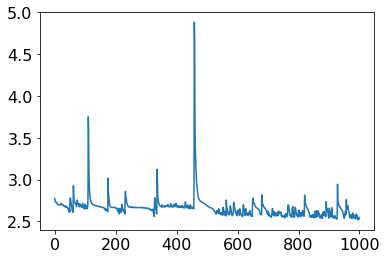

In [205]:
plt.plot(hist.history['loss'])


In [206]:
x = base_dist.sample(8000)
samples = [x]
names = [base_dist.name]
for bijector in reversed(trans_dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

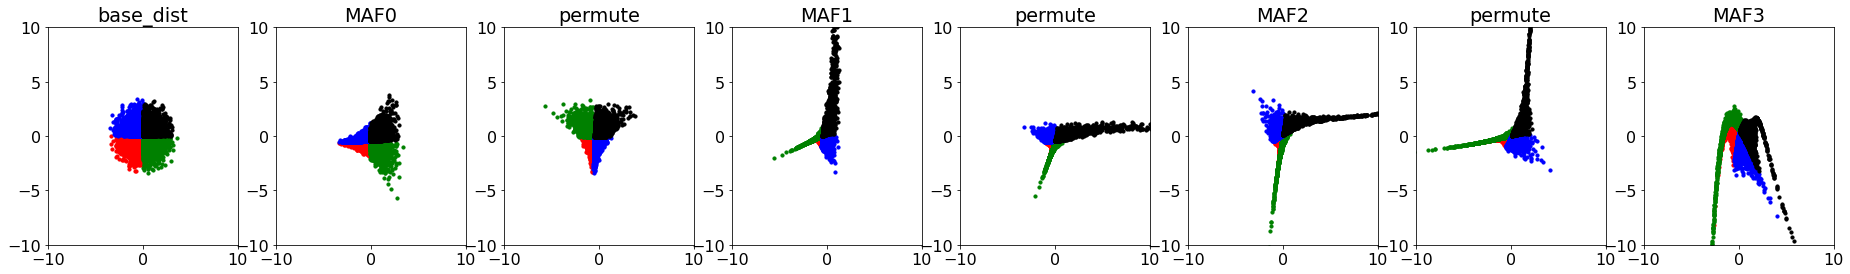

In [207]:
results = samples
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0].numpy()
for i in range(len(results)):
    X1 = results[i].numpy()
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([-10, 10])
    arr[i].set_ylim([-10, 10])
    arr[i].set_title(names[i])